In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from labbench import stopwatch

import matplotlib.pyplot as plt
import pickle

from seamf import trace


data_path = Path('data')

plt.rc('font',**{'family':'serif','serif':['Times New Roman']})
plt.rc('lines', linewidth=1)
# %config InlineBackend.figure_formats = ['svg']

### Multiprocessing aggregation (dask.dataframe)
This is shown aggregating a single trace type (pfp) since it loads a single dataframe.

In [10]:
from ziparchive import read_seamf_zipfile_as_ddf
import dask

partition_size = 100

# Generated the pickle by loading from the zipfile as follows:
with stopwatch():
    ddfs = read_seamf_zipfile_as_ddf(data_path/'NIT-2022-12-13.zip', partition_size=partition_size)

    day_ddfs = {
        k: ddfs[k].loc['2022-11-01']
        for k in ('psd', 'pfp', 'pvt', 'channel_metadata')
    }

    day = dask.compute(day_ddfs, num_workers=8)[0]

    # TODO: maybe there should be a convenience function to restore the MultiIndex as below?
    day['pfp'] = (
        day['pfp']
        .set_index(['frequency', 'capture_statistic', 'detector'], append=True, inplace=True)
        .astype('float32')
    )
    day['psd'] = (
        day['psd']
        .set_index(['frequency', 'capture_statistic'], append=True)
        .astype('float32')
    )
    day['pvt'] = (
        day['pvt']
        .set_index(['frequency', 'detector'], append=True)
        .astype('float32')
    )
    day['channel_metadata'].set_index(['frequency'], append=True, inplace=True)

<AxesSubplot: xlabel='datetime', ylabel='Channel power (dBm/10 MHz)'>

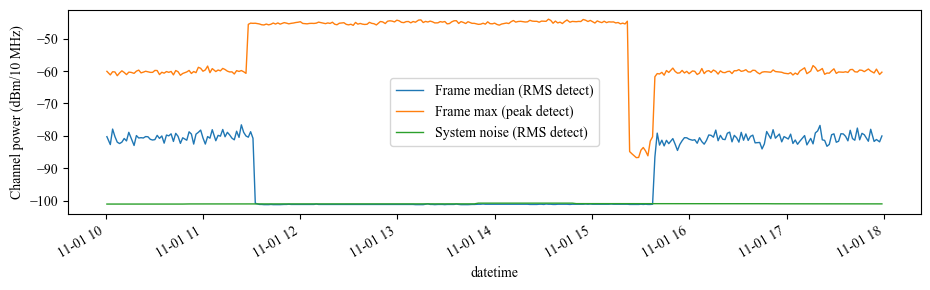

In [3]:
freq = 3605e6

pfp_indicators = {
    'Frame median (RMS detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='mean', detector='rms').quantile(0.5, axis=1),
    'Frame max (peak detect)':
        trace(day, 'pfp', frequency=freq, capture_statistic='max', detector='peak').max(axis=1),
    'System noise (RMS detect)':
        trace(day, 'channel_metadata', 'cal_noise_figure_dB', frequency=freq) + -174 + 70 - 1
}

pfp_indicators = pd.concat(pfp_indicators, axis=1)

fig, ax = plt.subplots(figsize=(11,3))
(
    pfp_indicators.loc['2022-11-01 10:00:00':'2022-11-01 18:00:00']
    .plot(ax=ax, ylabel='Channel power (dBm/10 MHz)')
)

In [4]:
pfp = trace(day, 'pfp')
psd = trace(day, 'psd')

pd.concat(
    [pfp.unstack(level=pfp.index.names[2:]),
     psd.unstack(level=psd.index.names[2:]),
    ],
    # keys=['pfp','psd'],
    axis=1
)


,,"(0.0, min, rms)","(0.0, max, rms)","(0.0, mean, rms)","(0.0, min, peak)","(0.0, max, peak)","(0.0, mean, peak)","(1.7857142857142855e-05, min, rms)","(1.7857142857142855e-05, max, rms)","(1.7857142857142855e-05, mean, rms)","(1.7857142857142855e-05, min, peak)",...,"(4920000.0, max)","(4920000.0, mean)","(4936000.0, max)","(4936000.0, mean)","(4952000.0, max)","(4952000.0, mean)","(4968000.0, max)","(4968000.0, mean)","(4984000.0, max)","(4984000.0, mean)"
datetime,frequency,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:04.012,3.655000e+09,-83.7500,-70.62500,-77.4375,-72.56250,-62.68750,-68.87500,-84.2500,-75.62500,-80.6250,-73.6875,...,-131.5000,-150.000,-131.5000,-149.625,-132.2500,-148.750,-132.5000,-148.875,-131.7500,-149.375
2022-11-01 00:00:10.013,3.665000e+09,-100.8125,-97.25000,-99.5625,-93.62500,-79.56250,-86.06250,-101.3125,-99.56250,-100.5625,-94.2500,...,-132.2500,-150.625,-133.1250,-151.250,-133.6250,-151.375,-132.8750,-151.750,-133.2500,-152.000
2022-11-01 00:00:14.719,3.675000e+09,-83.8125,-67.93750,-76.1875,-73.68750,-63.93750,-68.56250,-83.1250,-70.00000,-75.4375,-74.8125,...,-126.2500,-145.375,-126.3125,-145.375,-128.0000,-145.125,-128.1250,-145.500,-127.5625,-145.875
2022-11-01 00:00:19.461,3.685000e+09,-99.4375,-84.87500,-96.6875,-90.75000,-59.03125,-75.31250,-100.3125,-98.62500,-99.5000,-92.5000,...,-121.6875,-145.625,-122.0000,-145.750,-122.0625,-145.500,-123.4375,-145.375,-121.3750,-145.500
2022-11-01 00:00:24.640,3.695000e+09,-65.4375,-62.46875,-63.9375,-54.09375,-48.56250,-51.53125,-65.5000,-62.15625,-64.0000,-53.8750,...,-118.7500,-136.000,-118.7500,-136.000,-120.5000,-136.000,-120.5000,-136.000,-119.7500,-135.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01 23:59:36.152,3.635000e+09,-78.8750,-70.87500,-74.8750,-71.81250,-64.06250,-67.56250,-78.3750,-68.68750,-74.0000,-71.5000,...,-131.6250,-148.500,-131.0000,-148.500,-131.0000,-148.500,-132.2500,-149.000,-131.3750,-148.750
2022-11-01 23:59:41.387,3.645000e+09,-97.5000,-90.50000,-94.2500,-82.37500,-67.75000,-73.25000,-96.7500,-66.43750,-74.9375,-81.6250,...,-134.3750,-150.625,-132.5000,-150.500,-132.0000,-150.000,-132.7500,-150.250,-133.6250,-150.750
2022-11-01 23:59:46.840,3.655000e+09,-96.5625,-84.43750,-90.9375,-85.68750,-74.43750,-81.18750,-96.0000,-78.43750,-86.3125,-86.1250,...,-130.5000,-148.000,-130.3750,-148.625,-131.1250,-148.750,-130.6250,-148.875,-130.8750,-148.750


In [6]:
plot_pfp_span_with_detail?

Signature:
plot_pfp_span_with_detail(
    day,
    freq,
    pfp_indicators,
    span,
    detail_datetimes,
)
Docstring: <no docstring>
File:      c:\users\dkuester\documents\projects\sea\nasctn-sea-ingest\src\plots.py
Type:      function

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

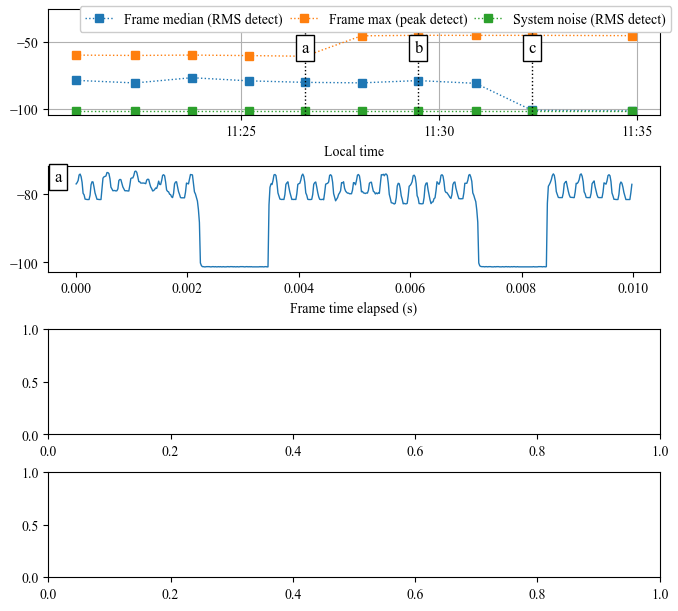

In [5]:
from plots import nearest_datetimes, plot_pfp_span_with_detail, plot_pvt_detail, plot_psd_detail

detail_trace_targets = {'a': '2022-11-01 11:26', 'b': '2022-11-01 11:30', 'c': '2022-11-01 11:33'}
mid_span = slice('2022-11-01 11:20:00','2022-11-01 11:35:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_start.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes)
fig.savefig('nit_event_2022-11_pvt_start.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_start.svg')

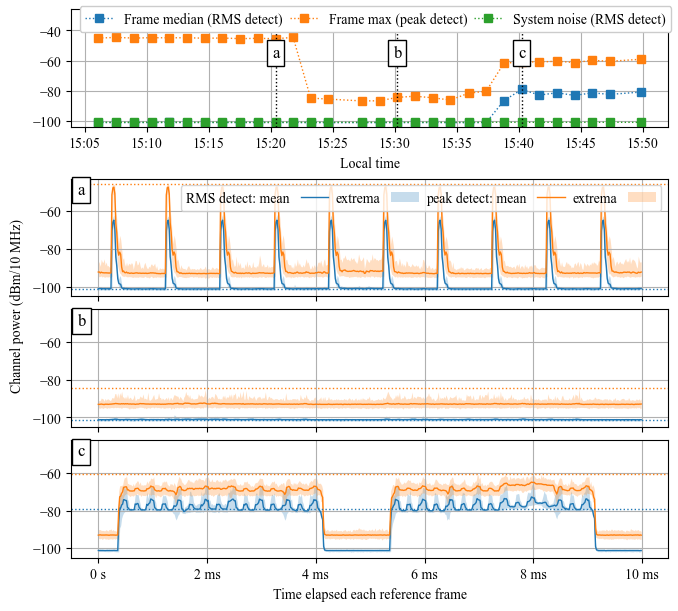

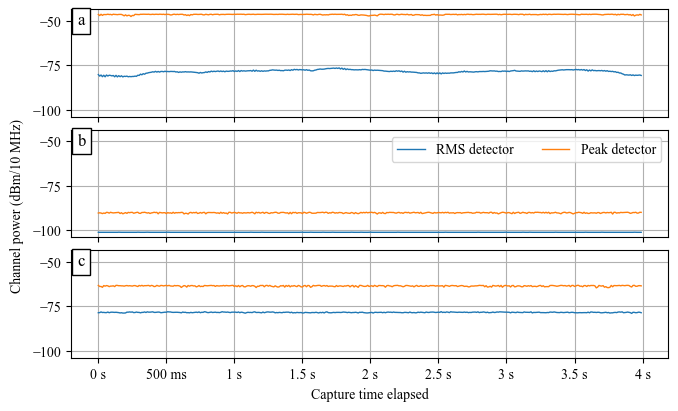

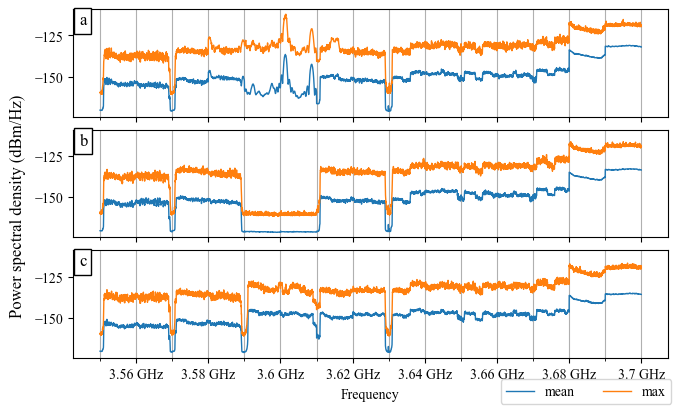

In [ ]:
detail_trace_targets = {'a': '2022-11-01 15:20', 'b': '2022-11-01 15:30', 'c': '2022-11-01 15:40'}
mid_span = slice('2022-11-01 15:05:00','2022-11-01 15:50:00')

detail_datetimes = {
    k: nearest_datetimes(pfp_indicators, [v])[0]
    for k,v in detail_trace_targets.items()
}

fig = plot_pfp_span_with_detail(day, freq, pfp_indicators, mid_span, detail_datetimes)
plt.savefig('nit_event_2022-11_pfp_end.svg')

fig = plot_pvt_detail(day, freq, detail_datetimes, legend_ax_index=1)
plt.savefig('nit_event_2022-11_pvt_end.svg')

fig = plot_psd_detail(day, detail_datetimes)
fig.savefig('nit_event_2022-11_psd_end.svg')

In [ ]:
pfp.index.get_level_values('datetime')[0]

Timestamp('2022-11-01 00:00:04.012000')